#CS6170 Computational Topology Final Project

Analysis of neuron images using Lucid and Dionysus

##Setup

In [1]:
#Installs
!pip install --quiet lucid==0.2.3
!pip -q install --verbose dionysus>=2.0.6
!pip -q install ripser

    100% |████████████████████████████████| 81kB 9.3MB/s 


In [0]:
# General support
import math
import tensorflow as tf
import numpy as np

# For plots
import matplotlib.pyplot as plt
from sklearn import manifold

#For saving
import pickle

#Lucid
from lucid.misc.io import save, show, load
import lucid.modelzoo.vision_models as models
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

# imports for homology computations
from ripser import Rips

In [0]:
###Plotting routines

###MDS Projection
def plot_mds(distance_matrix, description):
  embedding = manifold.MDS(n_components=2, dissimilarity='precomputed')
  transformed = embedding.fit_transform(distance_matrix)
  plt.scatter(transformed[:, 0], transformed[:, 1])
  plt.title(description)
    
def plot_tsne(distance_matrix, description):
  embedding = manifold.TSNE(n_components=2, metric='precomputed')
  transformed = embedding.fit_transform(distance_matrix)
  plt.scatter(transformed[:, 0], transformed[:, 1])
  plt.title(description)

def plot_histogram(data, description):
  plt.hist(data[np.nonzero(data)] , bins=35)
  plt.title(description)

##Computing the Homology of one neuron

In [0]:
#Importing GoogLeNet
model = models.InceptionV1()
model.load_graphdef()

###Naive with no regularizations

``

In [0]:
###Layer for experiments
layer = "mixed4a_pre_relu"

###Number of nodes in the layer
n_nodes = 508

###Helper lambda
channel = lambda l, n: objectives.channel(l, n)

###Optimization parameters
param_f = lambda: param.image(64)

###Setting the random seed for consistency
tf.random.set_random_seed(1723609)

In [0]:
"""
Generates a list of images
"""
def img_generator(n_nodes, node_generator, param_f):
  global model
  imgs = []
  for i in range(n_nodes):
    print(i)
    img = render.render_vis(model, node_generator(i), param_f)[0][0]
    imgs.append(img.reshape(img.shape[0] * img.shape[1], 3))
  return np.asarray(imgs)

"""
Image normalizer
imgs is an np array size (n x (64*64) x 3)
Returns a copy of the array
"""
def normalize(imgs):
  ret = np.copy(imgs)
  ret[;, ;, 2] = ret[;, ;, 0] + ret[;, ;, 1] + ret[;, ;, 2]
  for i in range(64):
    for j in range(64):
      ret[;, i+j, 0] = i
      ret[;, i+j, 1] = j
  return ret

"""
Runs a rips filtration on a single node
"""
def filtration(node, channel_f, opt_param, show_fig=False):
  global model
  print("Optimizing %d" % node)
  img = render.render_vis(model, channel_f(node), opt_param)
  img = img[0][0]
  img = img.reshape(img.shape[0]*img.shape[1], 3)
  rips = Rips()
  dgms = rips.fit_transform(img)
  if show_fig:
    rips.plot(dgms)
  return dgms
  
"""
Runs a rips filtration on a batch of n images. Returns an list of diagrams (np arrays)
"""
def n_nodes_filtration(n, channel_f, opt_param, show_fig=False):
  layer_dgms = []
  for i in range(n):
    layer_dgms.append(filtration(i, channel_f, opt_param, show_fig))
  return layer_dgms
  

An example filtration
Optimizing 507
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


512 1426.43



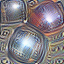

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


[array([[0.        , 0.00017263],
        [0.        , 0.00077204],
        [0.        , 0.00114512],
        ...,
        [0.        , 0.07404588],
        [0.        , 0.07971893],
        [0.        ,        inf]]), array([[0.1036428 , 0.11897291],
        [0.08911049, 0.09664762],
        [0.08722007, 0.09114525],
        ...,
        [0.00873464, 0.00901008],
        [0.00862477, 0.0103032 ],
        [0.00768946, 0.00866269]])]

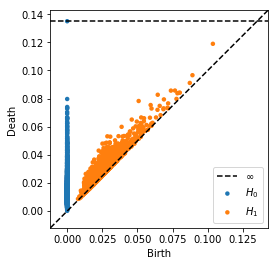

In [8]:
print("An example filtration")
node = 507
filtration(node, lambda n: objectives.channel("mixed4a_pre_relu", n), param_f, show_fig=True)

In [0]:
node_generator = lambda n: channel(layer, n)
dgms = n_nodes_filtration(n_nodes, node_generator, param_f)

with open("dgms.pkl", "wb") as dump_file: 
  pickle.dump(dgms, dump_file)
#Offline analysis of distance matrix

In [41]:
#Import distances
wasserstein_dim0 = np.load("wasserstein-0.npy")
wasserstein_dim1 = np.load("wasserstein-1.npy")
print("Max of dim0:")
print(np.amax(wasserstein_dim0.flatten()))
print("Max of dim1:")
print(np.amax(wasserstein_dim1.flatten()))

Max of dim0:
11.98443504981697
Max of dim1:
11.98443504981697


11.98443504981697
11.98443504981697


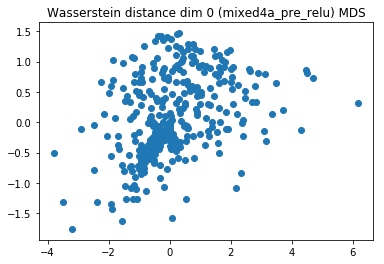

In [21]:
plot_mds(wasserstein_dim0, "Wasserstein distance dim 0 (mixed4a_pre_relu) MDS")

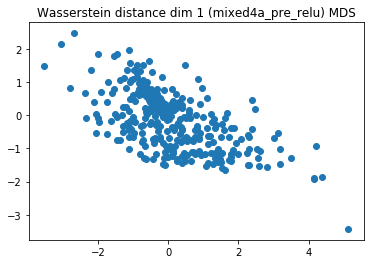

In [22]:
plot_mds(wasserstein_dim1, "Wasserstein distance dim 1 (mixed4a_pre_relu) MDS")

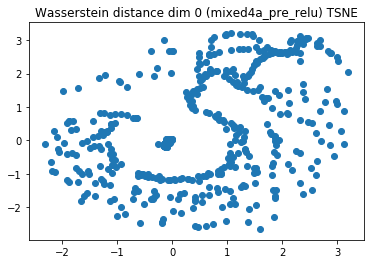

In [23]:
plot_tsne(wasserstein_dim0, "Wasserstein distance dim 0 (mixed4a_pre_relu) TSNE")

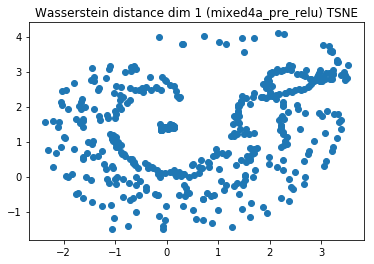

In [24]:
plot_tsne(wasserstein_dim1, "Wasserstein distance dim 1 (mixed4a_pre_relu) TSNE")

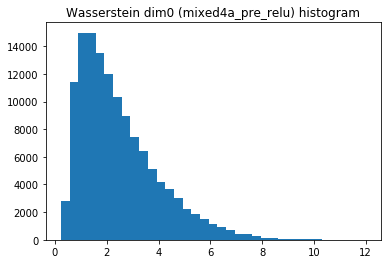

In [39]:
plot_histogram(wasserstein_dim0.flatten(), "Wasserstein dim0 (mixed4a_pre_relu) histogram")

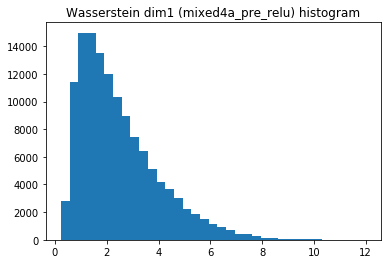

In [40]:
plot_histogram(wasserstein_dim1.flatten(), "Wasserstein dim1 (mixed4a_pre_relu) histogram")

Optimizing 0
512 106.95775



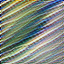

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 1
512 65.45712



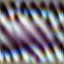

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 2
512 88.13659



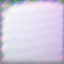

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 3
512 155.00334



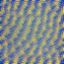

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 4
512 69.169136



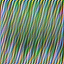

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 5
512 97.684494



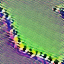

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 6
512 90.27031



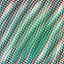

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 7
512 97.78798



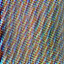

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 8
512 73.07701



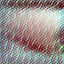

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 9
512 104.08612



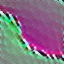

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 10
512 113.33163



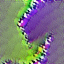

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 11
512 115.790375



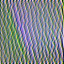

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 12
512 97.91257



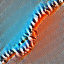

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 13
512 85.2283



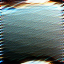

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 14
512 64.57998



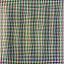

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 15
512 91.893265



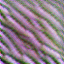

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 16
512 173.30449



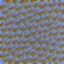

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 17
512 130.48946



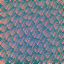

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 18
512 98.35461



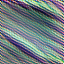

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 19
512 78.647644



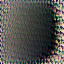

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 20
512 76.363304



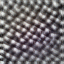

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 21
512 71.63089



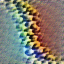

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 22
512 112.26239



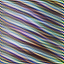

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 23
512 98.26138



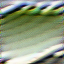

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 24
512 96.23565



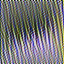

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 25
512 90.32101



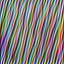

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 26
512 94.07364



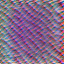

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 27
512 73.13111



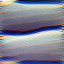

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 28
512 135.34747



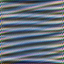

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 29
512 113.86284



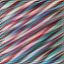

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 30
512 250.0711



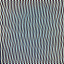

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 31
512 108.4489



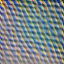

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 32
512 104.158966



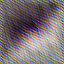

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 33
512 85.696304



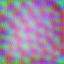

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 34
512 72.596306



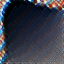

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 35
512 67.61772



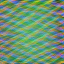

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 36
512 93.64287



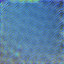

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 37
512 94.80092



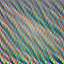

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 38
512 79.858315



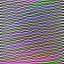

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 39
512 94.429634



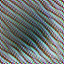

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 40
512 197.85155



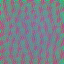

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 41
512 166.0627



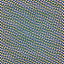

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 42
512 90.278496



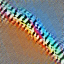

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 43
512 75.50918



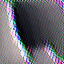

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 44
512 95.24823



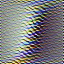

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 45
512 100.91822



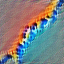

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 46
512 80.27304



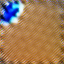

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 47
512 145.86478



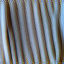

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 48
512 74.504395



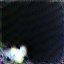

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 49
512 148.61876



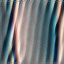

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 50
512 78.85912



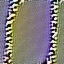

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 51
512 208.55978



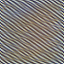

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 52
512 188.42244



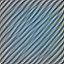

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 53
512 108.69637



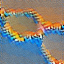

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 54
512 82.09762



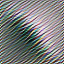

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 55
512 248.49863



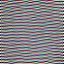

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 56
512 93.995



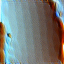

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 57
512 93.43823



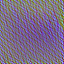

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 58
512 137.2394



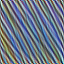

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 59
512 116.33496



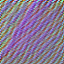

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 60
512 60.743336



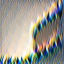

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 61
512 122.82192



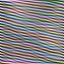

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 62
512 78.25816



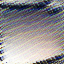

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 63
512 128.337



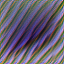

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [9]:
###Trying a different layer
###A purely convolutional layer (one of the beginning layers of the network)
layer = "conv2d1_pre_relu"

###Number of nodes in the layer
n_nodes = 64

node_generator = lambda n: objectives.channel(layer, n)

dgms = n_nodes_filtration(n_nodes, node_generator, param_f)

with open("dgms_conv2d1.pkl", "wb") as dump_file: 
  pickle.dump(dgms, dump_file)
#Offline analysis of distance matrix

###Using decorrelation and fft

In [0]:
###Starting with conv layer first
###Layer for experiments
layer = "conv2d1_pre_relu"

###Number of nodes in the layer
n_nodes = 64

###Helper lambda
channel = lambda l, n: objectives.channel(l, n)

###Optimization parameters
param_f = lambda: param.image(64, fft=True, decorrelate=True)

Optimizing 0
512 93.762405



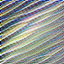

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 1
512 48.383293



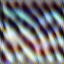

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 2
512 80.033035



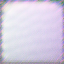

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 3
512 143.29225



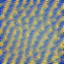

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 4
512 79.43764



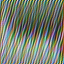

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 5
512 96.01317



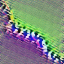

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 6
512 75.93746



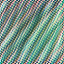

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 7
512 88.42143



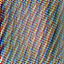

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 8
512 79.016106



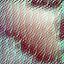

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 9
512 97.248215



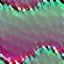

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 10
512 100.88688



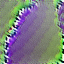

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 11
512 102.93772



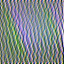

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 12
512 98.97401



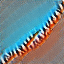

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 13
512 81.25187



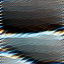

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 14
512 101.45121



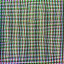

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 15
512 103.62373



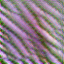

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 16
512 170.1721



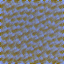

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 17
512 124.44023



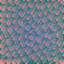

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 18
512 87.58868



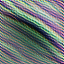

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 19
512 73.94726



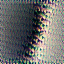

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 20
512 71.32506



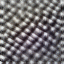

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 21
512 73.85741



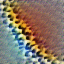

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 22
512 101.01989



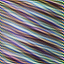

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 23
512 97.581474



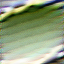

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 24
512 90.42595



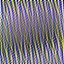

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 25
512 98.072914



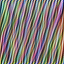

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 26
512 75.12074



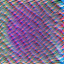

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 27
512 81.34316



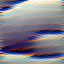

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 28
512 138.69771



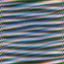

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 29
512 89.40324



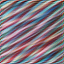

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 30
512 244.10907



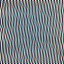

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 31
512 126.571686



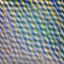

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 32
512 87.59722



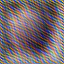

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 33
512 93.57422



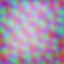

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 34
512 53.990517



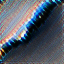

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 35
512 82.13444



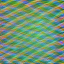

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 36
512 90.43038



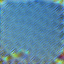

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 37
512 88.48151



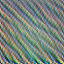

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 38
512 84.11296



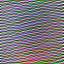

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 39
512 84.653015



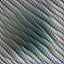

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 40
512 177.61682



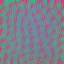

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 41
512 159.38931



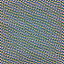

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 42
512 89.12731



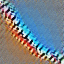

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 43
512 65.27739



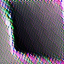

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 44
512 83.307076



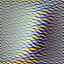

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 45
512 91.238594



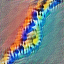

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 46
512 91.62089



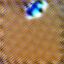

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 47
512 157.85286



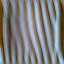

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 48
512 72.4547



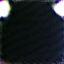

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 49
512 116.612595



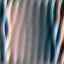

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 50
512 77.20329



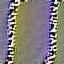

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 51
512 178.75487



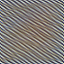

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 52
512 197.73788



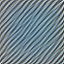

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 53
512 95.18355



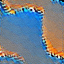

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 54
512 77.12043



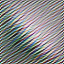

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 55
512 231.75648



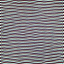

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 56
512 89.443054



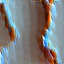

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 57
512 99.78966



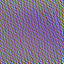

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 58
512 122.78069



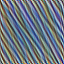

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 59
512 101.38428



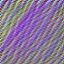

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 60
512 58.81612



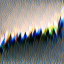

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 61
512 84.79913



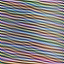

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 62
512 71.4401



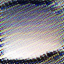

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 63
512 133.05843



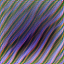

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [11]:
node_generator = lambda n: objectives.channel(layer, n)

dgms = n_nodes_filtration(n_nodes, node_generator, param_f)

with open("dgms_conv2d1_decorrelated.pkl", "wb") as dump_file: 
  pickle.dump(dgms, dump_file)
#Offline analysis of distance matrix

In [0]:
!conda install -c conda-forge gudhi 
print(len(dgms))
for x in range(len(dgms)):
  for y in range(len(dgms)):
    print(dgms[x][1].shape)
    print(y)
    print(p.bottleneck(dgms[x][0], dgms[y][0]))